In [5]:
# importing packages and data

import pandas as pd
import matplotlib.pyplot as plt
import math

df = pd.read_csv("extended_data.csv", 
dtype={0: float, 1: str, 2: float,  3: float,  4: float,  5: float,  6: float,  7: float,  8: int}
)

# fill missed funding periods with 0
df["funding"] = df["funding"].fillna(0)

# check number of assets
print(len(df["asset"].unique()))

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

57
Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate]
Index: []


In [6]:
# making time readable
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# getting returns and return and funding volatility

# asset retuns
df["returns"] = (
    df.groupby("asset")["close"]
      .transform(lambda x: x.pct_change())
)

# asset returns inclusive of funding
df["returns_funding"] = df["returns"] - df["funding"]

# next day asset returns inclusive of funding
df["next_returns_funding"] = (
    df.groupby("asset")["returns_funding"]
      .shift(-1)
)

In [7]:
# editing to remove what wont yet include returns and final day
df = df[df.groupby('asset').cumcount() > 0].copy()
df = df.groupby('asset').head(-1).copy()

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate, returns, returns_funding, next_returns_funding]
Index: []


In [8]:
idx_max = df["next_returns_funding"].idxmax()
print(df.loc[idx_max])
idx_min = df["next_returns_funding"].idxmin()
print(df.loc[idx_min])

timestamp               2025-05-07 20:00:00
asset                           MOODENG-USD
open                                0.03772
high                                0.06749
low                                 0.03772
close                               0.06609
volume                           34510390.0
funding                            0.000036
funding inaccurate                       24
returns                            0.752121
returns_funding                    0.752085
next_returns_funding               1.070981
Name: 7811, dtype: object
timestamp               2025-08-30 20:00:00
asset                               XPL-USD
open                                0.72323
high                                0.87782
low                                 0.71167
close                               0.87562
volume                            2327003.0
funding                           -0.009813
funding inaccurate                       24
returns                            0.210708
return

In [9]:
# create funding deciles
df["funding_decile"] = 0

# per day deciles across all assets
df['funding_decile'] = df.groupby('timestamp')['funding'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
1     2024-12-07 20:00:00  1000BONK-USD       0.043347       0.043347   
417   2024-12-07 20:00:00  1000PEPE-USD       0.026459       0.027093   
707   2024-12-07 20:00:00  1000SHIB-USD       0.030642       0.030642   
1356  2024-12-07 20:00:00       ADA-USD       1.233100       1.233100   
1797  2024-12-07 20:00:00       ARB-USD       1.173200       1.185800   
2216  2024-12-07 20:00:00      AVAX-USD      52.310000      53.250000   
2854  2024-12-07 20:00:00       BNB-USD     761.100000     761.100000   
3277  2024-12-07 20:00:00       BTC-USD  100120.200000  100448.200000   
3725  2024-12-07 20:00:00      DOGE-USD       0.458750       0.483400   
4420  2024-12-07 20:00:00       ETH-USD    4023.260000    4023.260000   
4966  2024-12-07 20:00:00      GOAT-USD       0.780800       0.780800   
6696  2024-12-07 20:00:00      LINK-USD      24.812000      27.423000   
7102  2024-12-07 20:00:00       LTC-USD     133.760

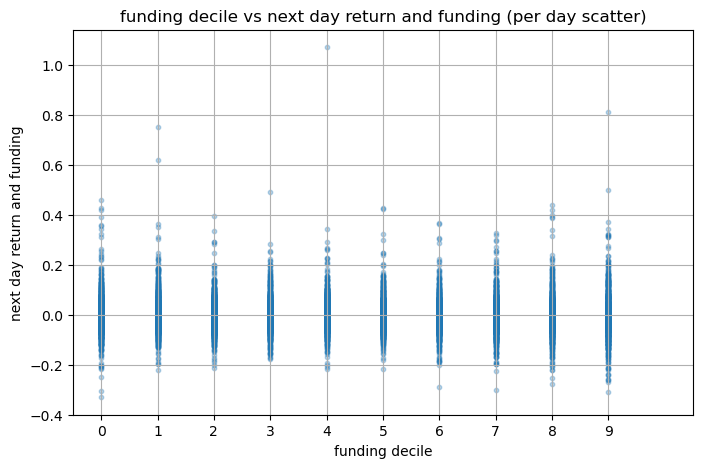

In [10]:
# scatter plot to gain initial intuiton
plt.figure(figsize=(8,5))
plt.scatter(
    df["funding_decile"], 
    df["next_returns_funding"], 
    alpha=0.3, 
    s=10
)

plt.xlabel("funding decile")
plt.ylabel("next day return and funding")
plt.title("funding decile vs next day return and funding (per day scatter)")
plt.grid(True)

plt.xlim(-0.5, 10.5)
plt.xticks(range(0, 10))
plt.show()

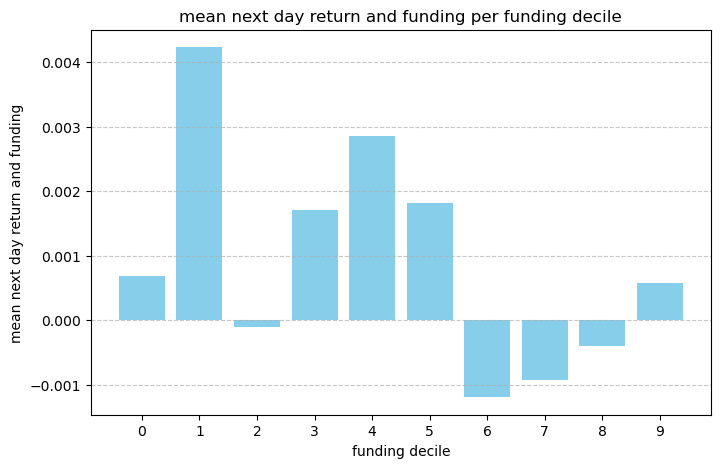

In [11]:
# decile plot to aim to see effects more clearly
decile_means = df.groupby("funding_decile")["next_returns_funding"].mean()

plt.figure(figsize=(8,5))
plt.bar(decile_means.index, decile_means.values, color="skyblue")
plt.xlabel("funding decile")
plt.ylabel("mean next day return and funding")
plt.title("mean next day return and funding per funding decile")
plt.xticks(decile_means.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

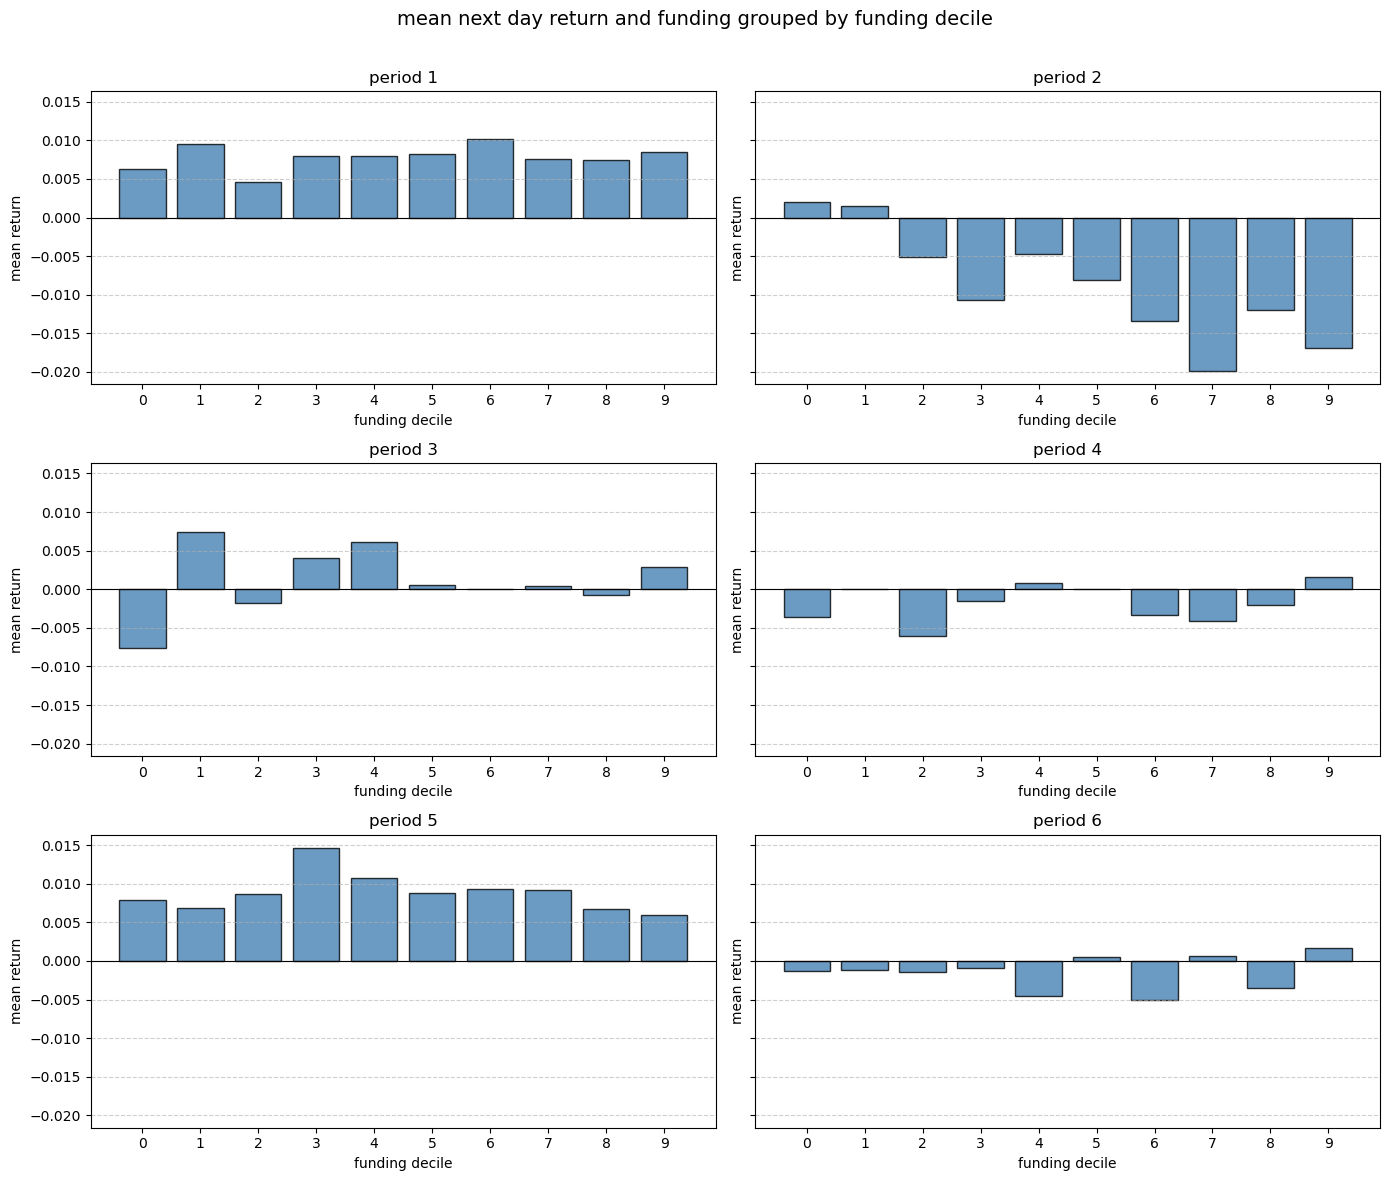

In [12]:
# checking deciles by periods
df["period"] = pd.qcut(df["timestamp"].rank(method="first"), 6, labels=False) + 1

# create subplots (3 rows × 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    subset = df[df["period"] == i]
    decile_means = subset.groupby("funding_decile")["next_returns_funding"].mean()
    
    bars = ax.bar(decile_means.index, decile_means.values, 
                  color="steelblue", edgecolor="black", alpha=0.8)
    
    # formatting
    ax.set_title(f"period {i}", fontsize=12)
    ax.set_xlabel("funding decile")
    ax.set_ylabel("mean return")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xticks(decile_means.index)

plt.suptitle("mean next day return and funding grouped by funding decile", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [13]:
# timeseries plot of returns
long_basket = df[df["funding_decile"].between(0, 1)].copy()

short_basket = df[df["funding_decile"].between(8, 9)].copy()
short_basket["next_returns_funding"] = short_basket["next_returns_funding"] * -1

long_short_basket = df[(df["funding_decile"] <= 1) | (df["funding_decile"] >= 8)].copy()
long_short_basket.loc[long_short_basket["funding_decile"] >= 8,"next_returns_funding"] *= -1

print(len(long_basket))
print(len(short_basket))
print(len(long_short_basket))

2933
2888
5821


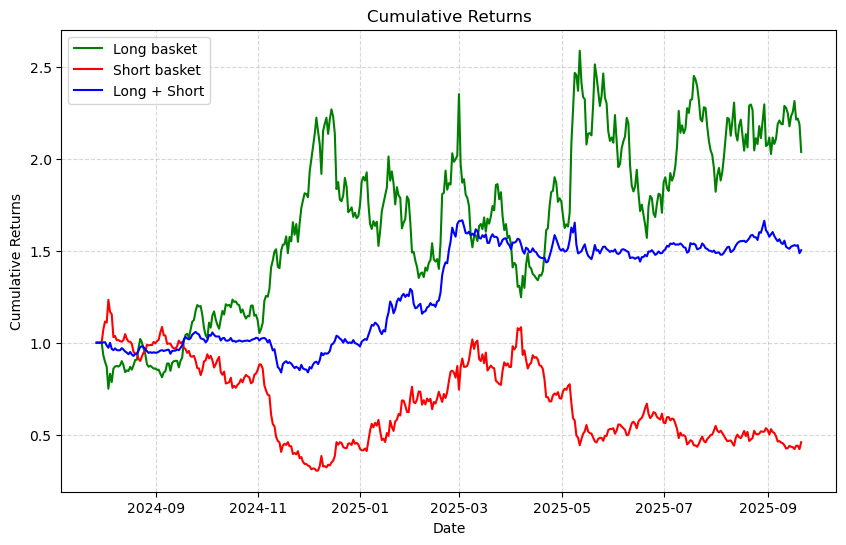

In [14]:
# Compute daily average returns
daily_long = long_basket.groupby("timestamp")["next_returns_funding"].mean()
daily_short = short_basket.groupby("timestamp")["next_returns_funding"].mean()
daily_long_short = long_short_basket.groupby("timestamp")["next_returns_funding"].mean()

# Compute cumulative returns
cum_long = (1 + daily_long).cumprod()
cum_short = (1 + daily_short).cumprod()
cum_long_short = (1 + daily_long_short).cumprod()

# Plot
plt.figure(figsize=(10,6))
plt.plot(cum_long.index, cum_long.values, color='green', label='Long basket')
plt.plot(cum_short.index, cum_short.values, color='red', label='Short basket')
plt.plot(cum_long_short.index, cum_long_short.values, color='blue', label='Long + Short')
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()